In [1]:
# Import Modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error,mean_squared_error,precision_score,r2_score,accuracy_score
plt.style.use('seaborn-whitegrid')
warnings.filterwarnings('ignore')

C:\Users\nirav\AppData\Local\Temp\ipykernel_16824\3271066116.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


# Data Analysis

In [2]:
# READ CSV
df = pd.read_csv('../Datasets/Train.csv')
df.describe()

,Year,Modis AOD,Insat AOD,BLH,PM2p5
count,336.000000,320.000000,335.000000,336.000000,307.000000
mean,2018.000000,0.572360,1.137243,1347.786354,70.589994
std,2.002983,0.229100,1.141232,569.137495,45.383944
min,2015.000000,0.155000,0.099633,188.043080,8.083705
25%,2016.000000,0.401000,0.273872,971.385922,37.749254
50%,2018.000000,0.527750,0.716424,1243.731700,54.790984
75%,2020.000000,0.761813,1.566922,1745.395825,99.480157
max,2021.000000,1.251000,4.665590,2924.515400,327.505618


In [3]:
df.head()

,City,Season,Year,Modis AOD,Insat AOD,BLH,PM2p5
0,Bihar_Patna,Winter,2015,1.042000,0.250223,974.9108,NaN
1,Bihar_Patna,Winter,2016,1.250667,0.185159,1250.5979,166.870381
2,Bihar_Patna,Winter,2017,0.801333,0.168022,1112.5720,153.334547
3,Bihar_Patna,Winter,2018,0.991333,0.821012,1125.3460,162.460784
4,Bihar_Patna,Winter,2019,0.844333,0.733033,1129.2333,144.468391


In [4]:
# Drop NaN values
df= df.dropna(subset=df.columns.values)
df.describe()

,Year,Modis AOD,Insat AOD,BLH,PM2p5
count,292.000000,292.000000,292.000000,292.000000,292.000000
mean,2018.160959,0.581920,1.157031,1404.847880,72.907573
std,1.922408,0.227521,1.111767,548.995261,45.210458
min,2015.000000,0.155000,0.099633,202.345720,17.796308
25%,2017.000000,0.405250,0.289225,1035.846850,39.499328
50%,2018.000000,0.540333,0.750375,1284.744250,56.317487
75%,2020.000000,0.773333,1.578022,1786.940225,103.206327
max,2021.000000,1.251000,4.658120,2924.515400,327.505618


In [5]:
df.City.unique()

array(['Bihar_Patna', 'Delhi', 'Gujarat_Ahmedabad', 'Haryana_Faridabad',
       'Karnataka_Bengaluru', 'Maharashtra_Mumbai', 'Maharashtra_Pune',
       'Tamil_Nadu_Chennai', 'Telangana_Hyderabad', 'UP_Agra',
       'UP_Kanpur', 'UP_Lucknow'], dtype=object)

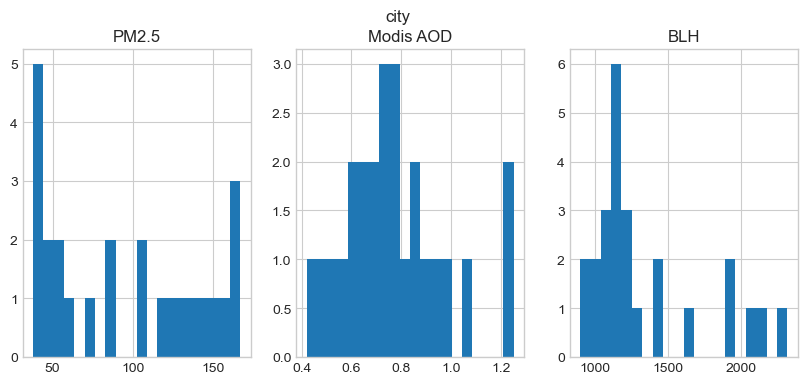

In [6]:
city_data = df[df['City'] == 'Bihar_Patna']
    
# Plot histograms for PM2.5, AOD, and BLH
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
axs[0].hist(city_data['PM2p5'], bins=20)
axs[0].set_title('PM2.5')
axs[1].hist(city_data['Modis AOD'], bins=20)
axs[1].set_title('Modis AOD')
axs[2].hist(city_data['BLH'], bins=20)
axs[2].set_title('BLH')
fig.suptitle('city')

# Display the histograms
plt.show()

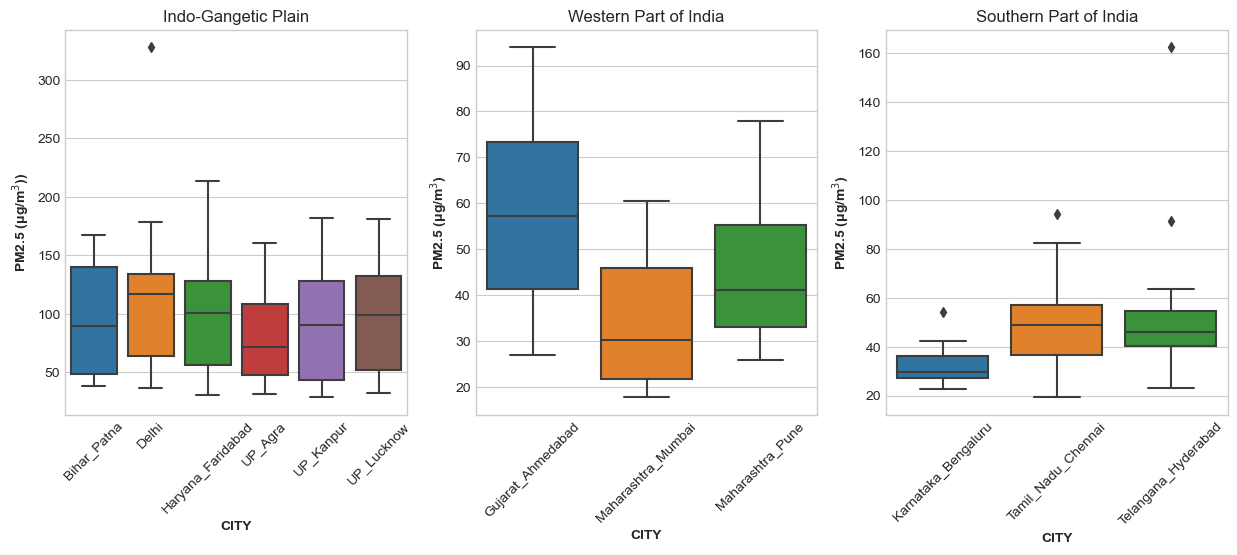

In [7]:
# OUTLIER DETECTION

# Define the regions and their corresponding cities
IGP_cities = ['Delhi', 'Haryana_Faridabad', 'UP_Agra', 'UP_Kanpur', 'UP_Lucknow', 'Bihar_Patna']
west_cities = ['Gujarat_Ahmedabad', 'Maharashtra_Mumbai', 'Maharashtra_Pune']
south_cities = ['Karnataka_Bengaluru', 'Tamil_Nadu_Chennai', 'Telangana_Hyderabad']

# Subset the data by region and PM2p5 levels
north_data = df[df['City'].isin(IGP_cities)][['City', 'Season', 'PM2p5']]
west_data = df[df['City'].isin(west_cities)][['City', 'Season', 'PM2p5']]
south_data = df[df['City'].isin(south_cities)][['City', 'Season', 'PM2p5']]

# Create a box plot of PM2p5 levels by season for each region
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))
sns.boxplot(x='City', y='PM2p5', data=north_data, ax=axs[0])
axs[0].set_title('Indo-Gangetic Plain')
sns.boxplot(x='City', y='PM2p5', data=west_data, ax=axs[1])
axs[1].set_title('Western Part of India')
sns.boxplot(x='City', y='PM2p5', data=south_data, ax=axs[2])
axs[2].set_title('Southern Part of India')
#fig.suptitle('Box plots of PM2.5 by season for different regions')

axs[0].tick_params(axis='x', labelrotation=45) # Rotate x-axis tick labels
axs[1].tick_params(axis='x', labelrotation=45) # Rotate x-axis tick labels
axs[2].tick_params(axis='x', labelrotation=45) # Rotate x-axis tick labels

axs[0].set_xlabel('CITY',weight='bold')
axs[1].set_xlabel('CITY',weight='bold')
axs[2].set_xlabel('CITY',weight='bold')

axs[0].set_ylabel('PM2.5 (μg/m$^3$))',weight='bold')
axs[1].set_ylabel('PM2.5 (μg/m$^3$)',weight='bold')
axs[2].set_ylabel('PM2.5 (μg/m$^3$)',weight='bold')
plt.show()

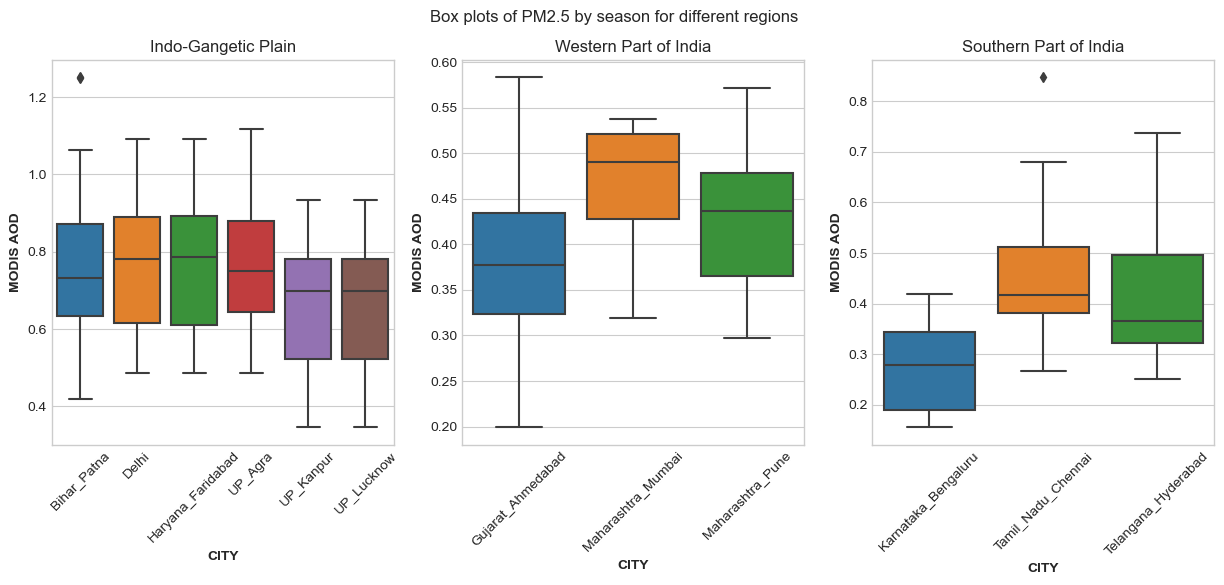

In [8]:
# OUTLIER DETECTION

# Define the regions and their corresponding cities
IGP_cities = ['Delhi', 'Haryana_Faridabad', 'UP_Agra', 'UP_Kanpur', 'UP_Lucknow', 'Bihar_Patna']
west_cities = ['Gujarat_Ahmedabad', 'Maharashtra_Mumbai', 'Maharashtra_Pune']
south_cities = ['Karnataka_Bengaluru', 'Tamil_Nadu_Chennai', 'Telangana_Hyderabad']

# Subset the data by region and PM2p5 levels
north_data = df[df['City'].isin(IGP_cities)][['City', 'Season', 'Modis AOD']]
west_data = df[df['City'].isin(west_cities)][['City', 'Season', 'Modis AOD']]
south_data = df[df['City'].isin(south_cities)][['City', 'Season', 'Modis AOD']]

# Create a box plot of PM2p5 levels by season for each region
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))
sns.boxplot(x='City', y='Modis AOD', data=north_data, ax=axs[0])
axs[0].set_title('Indo-Gangetic Plain')
sns.boxplot(x='City', y='Modis AOD', data=west_data, ax=axs[1])
axs[1].set_title('Western Part of India')
sns.boxplot(x='City', y='Modis AOD', data=south_data, ax=axs[2])
axs[2].set_title('Southern Part of India')
fig.suptitle('Box plots of PM2.5 by season for different regions')

axs[0].tick_params(axis='x', labelrotation=45) # Rotate x-axis tick labels
axs[1].tick_params(axis='x', labelrotation=45) # Rotate x-axis tick labels
axs[2].tick_params(axis='x', labelrotation=45) # Rotate x-axis tick labels

axs[0].set_xlabel('CITY',weight='bold')
axs[1].set_xlabel('CITY',weight='bold')
axs[2].set_xlabel('CITY',weight='bold')

axs[0].set_ylabel('MODIS AOD',weight='bold')
axs[1].set_ylabel('MODIS AOD',weight='bold')
axs[2].set_ylabel('MODIS AOD',weight='bold')
plt.show()

In [9]:
df.describe()

,Year,Modis AOD,Insat AOD,BLH,PM2p5
count,292.000000,292.000000,292.000000,292.000000,292.000000
mean,2018.160959,0.581920,1.157031,1404.847880,72.907573
std,1.922408,0.227521,1.111767,548.995261,45.210458
min,2015.000000,0.155000,0.099633,202.345720,17.796308
25%,2017.000000,0.405250,0.289225,1035.846850,39.499328
50%,2018.000000,0.540333,0.750375,1284.744250,56.317487
75%,2020.000000,0.773333,1.578022,1786.940225,103.206327
max,2021.000000,1.251000,4.658120,2924.515400,327.505618


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 292 entries, 1 to 335
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   City       292 non-null    object 
 1   Season     292 non-null    object 
 2   Year       292 non-null    int64  
 3   Modis AOD  292 non-null    float64
 4   Insat AOD  292 non-null    float64
 5   BLH        292 non-null    float64
 6   PM2p5      292 non-null    float64
dtypes: float64(4), int64(1), object(2)
memory usage: 18.2+ KB


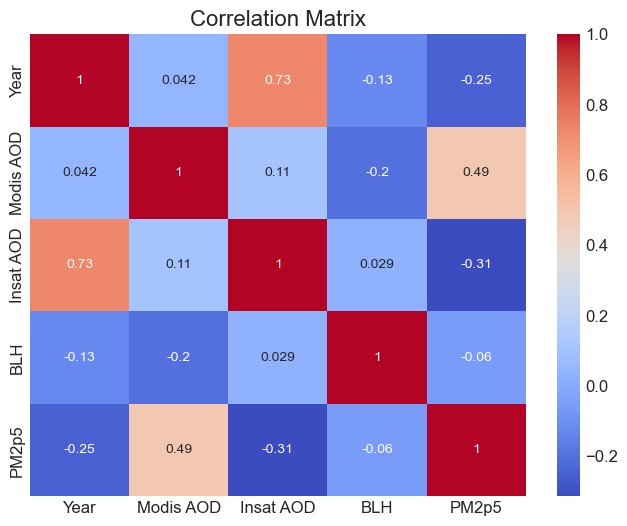

In [11]:
# calculate the correlation matrix
corr_matrix = df.corr()

# set the figure size
fig, ax = plt.subplots(figsize=(8, 6))

# create a heatmap with the correlation matrix
heatmap = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=ax)

# set the font size of the axis labels
heatmap.tick_params(axis='both', labelsize=12)

# set the font size of the title
heatmap.set_title('Correlation Matrix', fontsize=16)

# add a color bar
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)

plt.show()

In [12]:
# Data Type
df.dtypes

City          object
Season        object
Year           int64
Modis AOD    float64
Insat AOD    float64
BLH          float64
PM2p5        float64
dtype: object

In [13]:
df

,City,Season,Year,Modis AOD,Insat AOD,BLH,PM2p5
1,Bihar_Patna,Winter,2016,1.250667,0.185159,1250.5979,166.870381
2,Bihar_Patna,Winter,2017,0.801333,0.168022,1112.5720,153.334547
3,Bihar_Patna,Winter,2018,0.991333,0.821012,1125.3460,162.460784
4,Bihar_Patna,Winter,2019,0.844333,0.733033,1129.2333,144.468391
5,Bihar_Patna,Winter,2020,1.063667,0.761123,1060.4095,139.467262
...,...,...,...,...,...,...,...
331,UP_Lucknow,Post-Monsoon,2017,0.850000,0.607114,1417.4482,167.764973
332,UP_Lucknow,Post-Monsoon,2018,0.680000,0.548731,1835.0261,115.422935
333,UP_Lucknow,Post-Monsoon,2019,0.934500,0.813278,1228.4349,117.727001
334,UP_Lucknow,Post-Monsoon,2020,0.784500,0.674001,1519.3025,107.147698


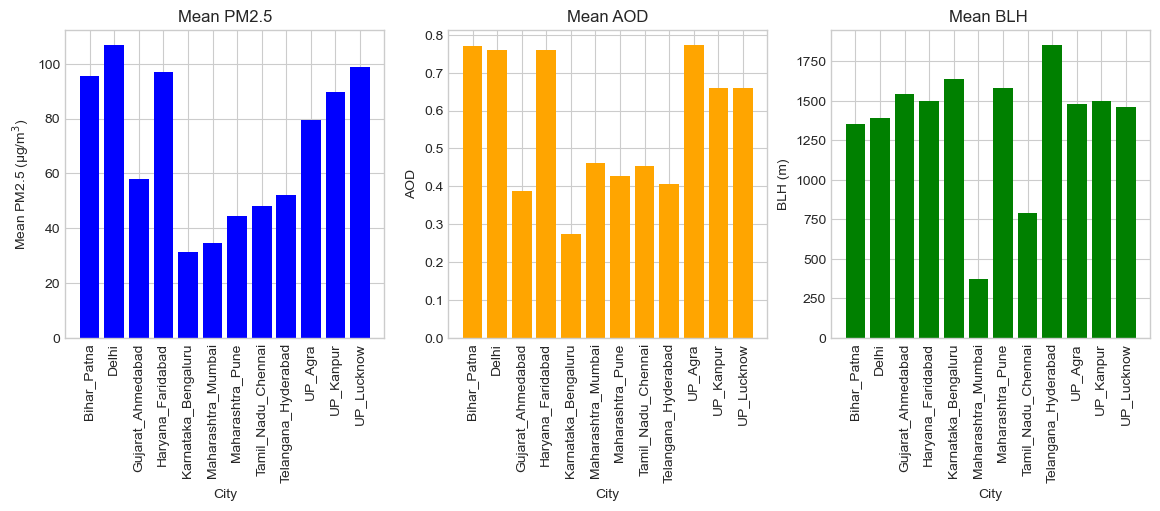

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

ax = axes[0]
grouped_df = df.groupby(['City']).mean().reset_index()

# Create a bar chart of the mean PM2.5 levels for each city
ax.bar(grouped_df['City'], grouped_df['PM2p5'],color='b')
# Add axis labels and a title
ax.set_xlabel('City')
ax.set_ylabel('Mean PM2.5 (μg/m$^3$)')
ax.set_title('Mean PM2.5')
ax.set_xticklabels(grouped_df['City'], rotation=90)


ax = axes[1]
grouped_df = df.groupby(['City']).mean().reset_index()

# Create a bar chart of the mean PM2.5 levels for each city
ax.bar(grouped_df['City'], grouped_df['Modis AOD'],color='orange')
# Add axis labels and a title
ax.set_xlabel('City')
ax.set_ylabel('AOD')
ax.set_title('Mean AOD')
ax.set_xticklabels(grouped_df['City'], rotation=90)

ax = axes[2]
grouped_df = df.groupby(['City']).mean().reset_index()

# Create a bar chart of the mean PM2.5 levels for each city
ax.bar(grouped_df['City'], grouped_df['BLH'],color='green')
# Add axis labels and a title
ax.set_xlabel('City')
ax.set_ylabel('BLH (m)')
ax.set_title('Mean BLH ')
ax.set_xticklabels(grouped_df['City'], rotation=90)
plt.show()


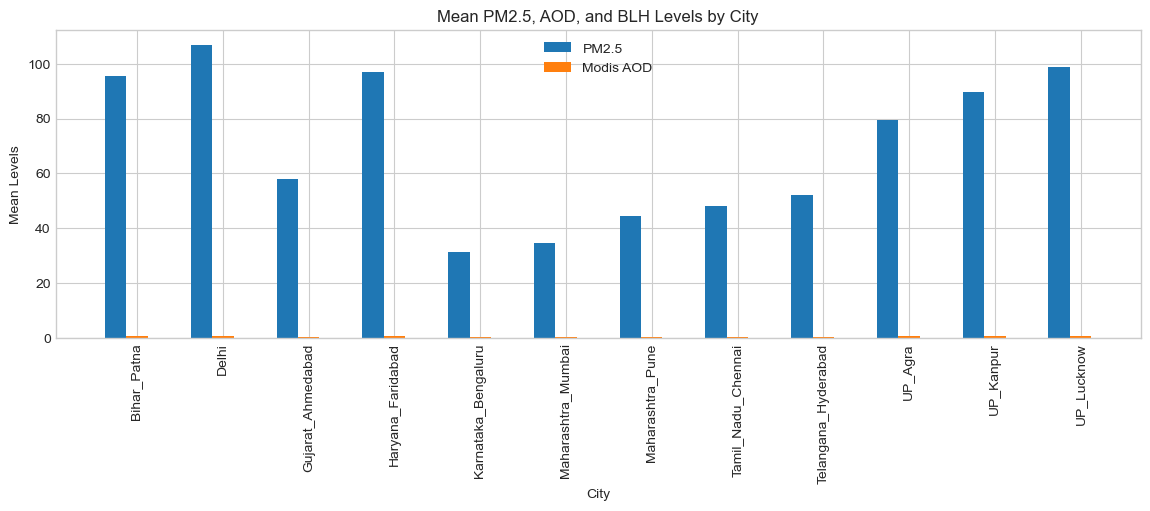

In [15]:
grouped_df = df.groupby(['City']).mean().reset_index()

# Create a bar chart with three bars for each city
fig, ax = plt.subplots(figsize=(14, 4))
bar_width = 0.25

ax.bar(np.arange(len(grouped_df)), grouped_df['PM2p5'], width=bar_width, label='PM2.5')
ax.bar(np.arange(len(grouped_df))+bar_width, grouped_df['Modis AOD'], width=bar_width, label='Modis AOD')
#ax.bar(np.arange(len(grouped_df))+2*bar_width, grouped_df['BLH'], width=bar_width, label='BLH')

# Add axis labels, title, and legend
ax.set_xlabel('City')
ax.set_ylabel('Mean Levels')
ax.set_title('Mean PM2.5, AOD, and BLH Levels by City')
ax.set_xticks(np.arange(len(grouped_df))+bar_width)
ax.set_xticklabels(grouped_df['City'], rotation=90)
ax.legend()

# Show the plot
plt.show()

# Preprocessing

In [16]:
print(f"CITY:{df.City.unique()} \n Season:{df.Season.unique()}")
#df[0:20]

CITY:['Bihar_Patna' 'Delhi' 'Gujarat_Ahmedabad' 'Haryana_Faridabad'
 'Karnataka_Bengaluru' 'Maharashtra_Mumbai' 'Maharashtra_Pune'
 'Tamil_Nadu_Chennai' 'Telangana_Hyderabad' 'UP_Agra' 'UP_Kanpur'
 'UP_Lucknow'] 
 Season:['Winter' 'Pre-Monsoon' 'Monsoon' 'Post-Monsoon']


In [17]:
# ENCODING CITY AND SEASON
le = LabelEncoder()
df['Season'] = le.fit_transform(df['Season'])
df['City'] = le.fit_transform(df['City'])
print(f"CITY:{df.City.unique()} \n Season:{df.Season.unique()}")
#df[0:20]

CITY:[ 0  1  2  3  4  5  6  7  8  9 10 11] 
 Season:[3 2 0 1]


In [18]:
# Scale AOD,BLH,PM2.5
scaler = StandardScaler()
num_cols = ['Modis AOD', 'Insat AOD', 'BLH']
df[num_cols] = scaler.fit_transform(df[num_cols])


In [19]:
df

,City,Season,Year,Modis AOD,Insat AOD,BLH,PM2p5
1,0,3,2016,2.944313,-0.875670,-0.281450,166.870381
2,0,3,2017,0.966017,-0.891111,-0.533297,153.334547
3,0,3,2018,1.802537,-0.302757,-0.509989,162.460784
4,0,3,2019,1.155335,-0.382028,-0.502896,144.468391
5,0,3,2020,2.121002,-0.356718,-0.628475,139.467262
...,...,...,...,...,...,...,...
331,11,1,2017,1.180284,-0.495482,0.022991,167.764973
332,11,1,2018,0.431819,-0.548086,0.784919,115.422935
333,11,1,2019,1.552315,-0.309726,-0.321890,117.727001
334,11,1,2020,0.891905,-0.435217,0.208838,107.147698


In [20]:
df.describe()

,City,Season,Year,Modis AOD,Insat AOD,BLH,PM2p5
count,292.000000,292.000000,292.000000,2.920000e+02,2.920000e+02,2.920000e+02,292.000000
mean,5.541096,1.506849,2018.160959,7.300097e-17,6.691755e-17,-4.258390e-17,72.907573
std,3.595772,1.088816,1.922408,1.001717e+00,1.001717e+00,1.001717e+00,45.210458
min,0.000000,0.000000,2015.000000,-1.879618e+00,-9.527301e-01,-2.194129e+00,17.796308
25%,2.000000,1.000000,2017.000000,-7.778330e-01,-7.819044e-01,-6.732927e-01,39.499328
50%,6.000000,1.500000,2018.000000,-1.830968e-01,-3.664020e-01,-2.191455e-01,56.317487
75%,9.000000,2.000000,2020.000000,8.427407e-01,3.793187e-01,6.971796e-01,103.206327
max,11.000000,3.000000,2021.000000,2.945781e+00,3.154528e+00,2.772841e+00,327.505618


In [21]:
# Take out Validaton Test CASE 

validate_seasons = []
for city in range(12):
    city_data = df[df['City'] == city]
    for season in range(0, 4):
        season_data = city_data[(city_data['Season'] == season) & (city_data['Year'] == 2019)]
        if len(season_data) >= 1:
            season_sample = season_data.sample(n=1)
            validate_seasons.append(season_sample)

val_data = pd.concat(validate_seasons)

len(val_data)
print(len(df))
df = df.drop(val_data.index)
print(len(df))

292
244


# Splitting Dataset into train and test dataset

In [22]:
#Dropping outlier
# index_to_drop = df[df['PM2p5'] == -0.21176474917579016].index
# df = df.drop(index_to_drop)

# Split data into train and test sets
X = df.drop('PM2p5', axis=1)
y = df['PM2p5']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)


In [23]:
print('Total',df.shape)
print('X',X_train.shape,X_test.shape)
print('Y',y_train.shape,y_test.shape)

Total (244, 7)
X (195, 6) (49, 6)
Y (195,) (49,)


# XGBoost

In [24]:
# Define XGBoost regressor
model = XGBRegressor(eval_metric='rmse',objective="reg:squarederror")

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [100,105,110],
    'max_depth': [5,6,7],
    'min_child_weight':[0,1,2],
    'learning_rate': [0.1],
    'colsample_bytree': [0.78],
    'subsample': [0.68,0.7,0.72],
    'lambda':[5,6.8,7],
    'alpha':[0.02,0.025],
    'gamma':[0.01,0.009],
}

# Define grid search object
grid = GridSearchCV(model, param_grid=param_grid, cv=5, n_jobs=-1,verbose=2,scoring=['neg_root_mean_squared_error', 'r2'],refit='r2')

# Fit grid search object to data
grid.fit(X_train, y_train,verbose=0)

# Predict on test set
y_pred = grid.predict(X_test)


# Compute metrics
print("\nBest Parameters found:",grid.best_params_)
print("\nBest Score:", grid.best_score_)
print(f'\nMean squared error: {mean_squared_error(y_test, y_pred)}')
print(f"\nR_squared : {r2_score(y_test, y_pred)}")
print(f"\nRMSE : {np.sqrt(mean_squared_error(y_test, y_pred))}")

Fitting 5 folds for each of 972 candidates, totalling 4860 fits

Best Parameters found: {'alpha': 0.02, 'colsample_bytree': 0.78, 'gamma': 0.01, 'lambda': 6.8, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 110, 'subsample': 0.7}

Best Score: 0.6902193641675934

Mean squared error: 360.7622677927778

R_squared : 0.8165661797018019

RMSE : 18.993742858972734


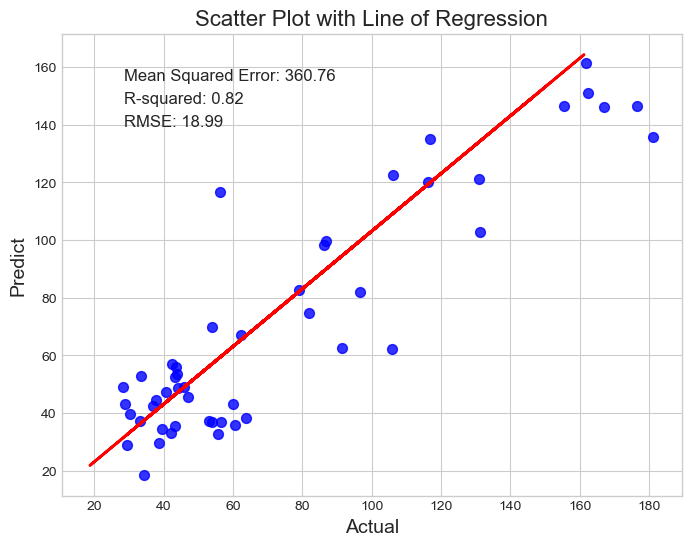

In [25]:
# calculate the line of regression using numpy
slope, intercept = np.polyfit(y_pred, y_test, 1)
line_of_regression = slope * y_pred + intercept

# calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

# plot
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(y_test, y_pred, s=50, alpha=0.8,color='b')
ax.plot(y_pred, line_of_regression, color='r', linewidth=2)
ax.set_xlabel('Actual', fontsize=14)
ax.set_ylabel('Predict', fontsize=14)
ax.set_title('Scatter Plot with Line of Regression', fontsize=16)

# add a legend with evaluation metrics
ax.text(0.1, 0.9, f'Mean Squared Error: {mse:.2f}', transform=ax.transAxes, fontsize=12)
ax.text(0.1, 0.85, f'R-squared: {r_squared:.2f}', transform=ax.transAxes, fontsize=12)
ax.text(0.1, 0.8, f'RMSE: {rmse:.2f}', transform=ax.transAxes, fontsize=12)

#plt.savefig('../plots/model/xgboost_model_3.png', dpi=300, bbox_inches='tight')

plt.show()

In [26]:
df

,City,Season,Year,Modis AOD,Insat AOD,BLH,PM2p5
1,0,3,2016,2.944313,-0.875670,-0.281450,166.870381
2,0,3,2017,0.966017,-0.891111,-0.533297,153.334547
3,0,3,2018,1.802537,-0.302757,-0.509989,162.460784
5,0,3,2020,2.121002,-0.356718,-0.628475,139.467262
6,0,3,2021,2.945781,0.353924,-0.465177,155.927778
...,...,...,...,...,...,...,...
330,11,1,2016,0.852280,-0.871382,-0.103256,153.011646
331,11,1,2017,1.180284,-0.495482,0.022991,167.764973
332,11,1,2018,0.431819,-0.548086,0.784919,115.422935
334,11,1,2020,0.891905,-0.435217,0.208838,107.147698


In [27]:
x_val_data = val_data.drop('PM2p5', axis=1)
y_val_data = val_data.PM2p5

# Predict the PM2.5 values using the trained model
y_pred = grid.predict(x_val_data)

# Combine the predicted and actual values for each city and season into a single DataFrame
predictions = pd.DataFrame({'City': val_data.City, 'Season': val_data.Season, 'Actual PM2.5': y_val_data, 'Predicted PM2.5': y_pred})
len(predictions)

48

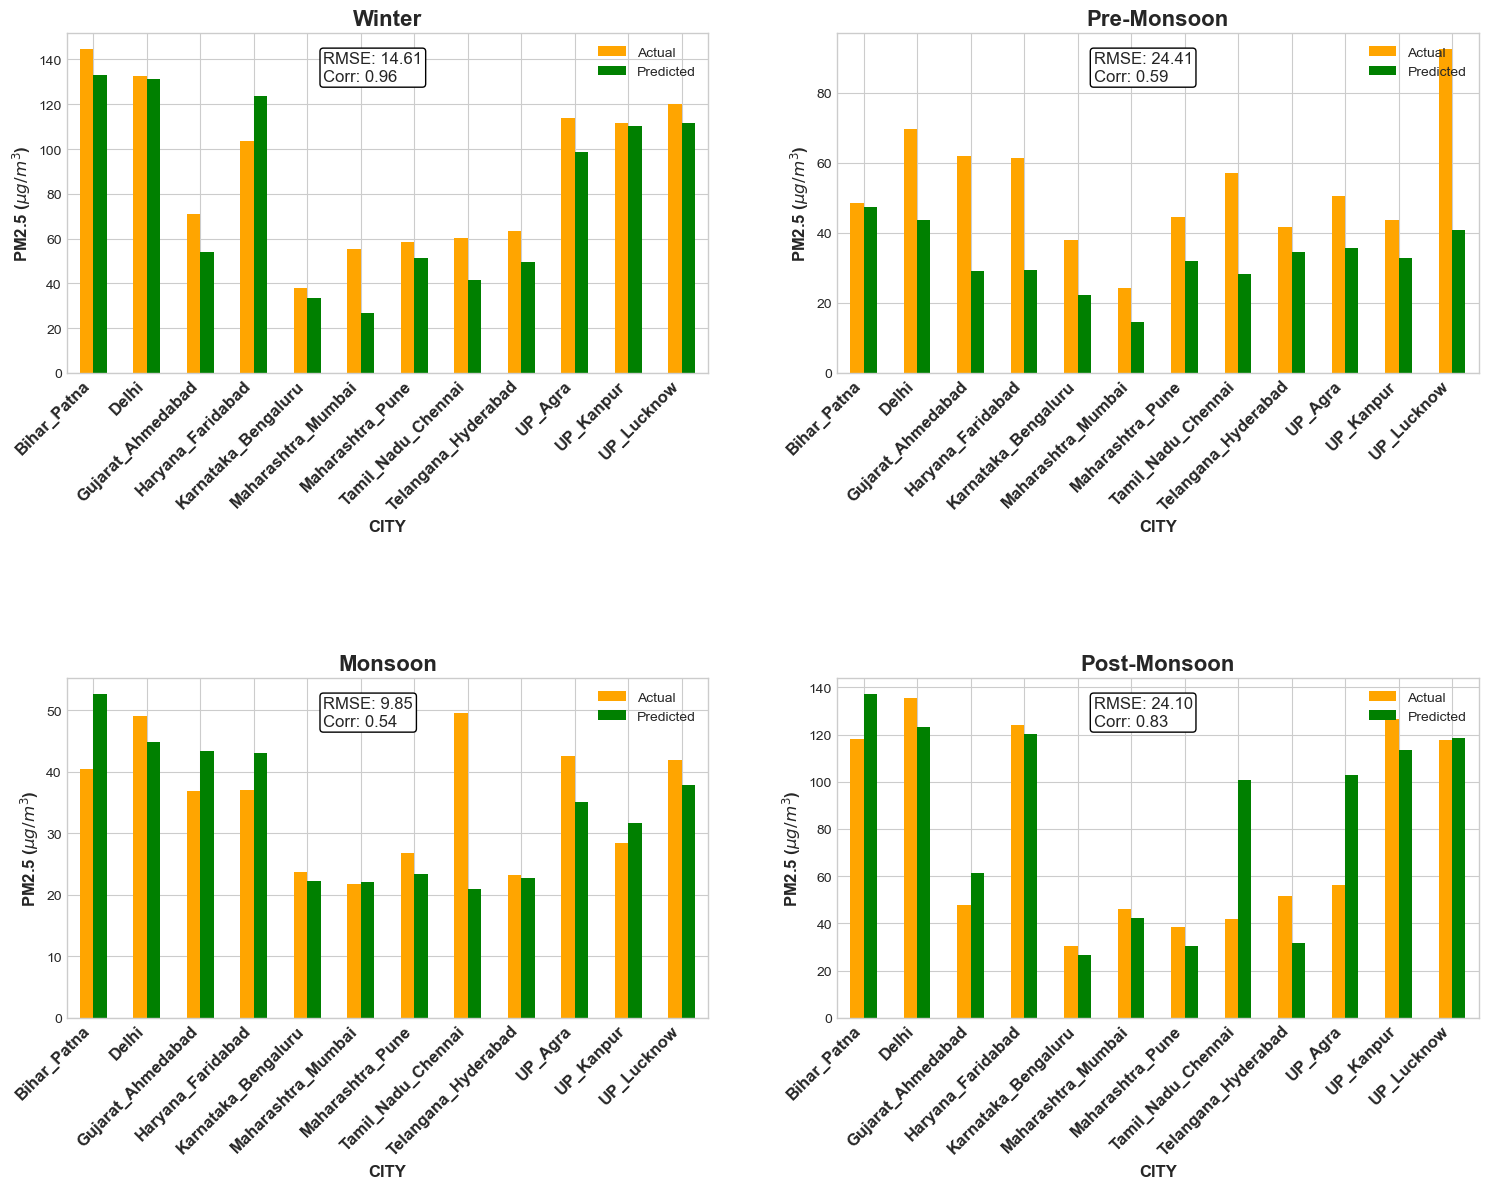

In [30]:
# Create four subplots for each season
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

Season_name = ['Winter','Pre-Monsoon','Monsoon','Post-Monsoon']

idx = 0
# Filter the data by season and plot the bar graph
for ax, season_encode in zip(axes.flatten(), [3,2,0,1]):
    
    df = predictions[predictions['Season'] == season_encode].sort_values('City')
    df.index = ['Bihar_Patna', 'Delhi', 'Gujarat_Ahmedabad', 'Haryana_Faridabad',
                'Karnataka_Bengaluru', 'Maharashtra_Mumbai', 'Maharashtra_Pune',
                'Tamil_Nadu_Chennai', 'Telangana_Hyderabad', 'UP_Agra', 'UP_Kanpur', 'UP_Lucknow']

    df = df.drop(columns=['City', 'Season'])
    df.plot(kind='bar', ax=ax, legend=False, color=['orange', 'green'])
    ax.set_title(Season_name[idx], fontsize=16,weight='bold')
    ax.set_xlabel('CITY', fontsize=12,weight='bold')
    ax.set_ylabel('PM2.5 ($\mu g/m^3$)', fontsize=12,weight='bold')
    ax.set_xticklabels(df.index, fontsize=12, weight='bold', rotation=45, ha='right')
   
    # Calculate RMSE and correlation coefficient
    rmse = np.sqrt(mean_squared_error(df['Actual PM2.5'], df['Predicted PM2.5']))
    corr = np.corrcoef(df['Actual PM2.5'], df['Predicted PM2.5'])[0, 1]
    
    # Add RMSE and correlation coefficient to top left corner
    ax.text(0.4, 0.86, f'RMSE: {rmse:.2f}\nCorr: {corr:.2f}', transform=ax.transAxes, fontsize=12,bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))
    
    # Move legends to top right corner
    ax.legend(['Actual', 'Predicted', 'Actual (Test)', 'Predicted (Test)'], fontsize=10, loc='upper right')
    
    # increase season idx
    idx += 1
    
# Add a common title for the entire plot
#fig.suptitle('Seasonal Prediction, 2019', fontsize=16,weight='bold')

# Adjust the layout of the subplots
plt.tight_layout()

# Adjust the layout of the subplots
plt.subplots_adjust(hspace=0.9, wspace=0.2)

#plt.savefig('../plots/model/Seasonal_Prediction_xgboost.png', dpi=300)
# Show the plot
plt.show()
